In [1]:
# API Keys retrieval
from dotenv import load_dotenv
import os
load_dotenv()

# Data Collection
import requests
import pprint

# Storing Data
import uuid 
import requests
import pinecone
from transformers import AutoTokenizer, AutoModel

# ChromaDB
import os
import chromadb
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.vectorstores import Chroma

from langchain.embeddings import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langchain_core.messages import HumanMessage, SystemMessage

# Data Wrangling & Cleaning
import json
import pandas as pd
import torch
import hashlib
import datetime
import re
from dateutil.relativedelta import relativedelta
import re
import jsonlines

c:\Python312\Lib\importlib\__init__.py:90: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  return _bootstrap._gcd_import(name[level:], package, level)


For this part of the RAG model; we'll focus on using templates from langchain-crash-course-main

In [5]:
current_dir = os.getcwd() # NOTE: use this for .ipynb files
persistent_directory = os.path.join(current_dir, "db", "chroma_db_with_metadata")

# Initialize embedding model
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

# embeddings = OpenAIEmbeddings(
#     model="text-embedding-3-small"
# )

# Init ChromaDB collection once
collection_name = "jobs_collection"
db = Chroma(
    collection_name=collection_name,
    persist_directory=persistent_directory,
    embedding_function=embeddings
)

In [ ]:
# Load the existing vector store with the embedding function
db = Chroma(
    persist_directory=persistent_directory,
    embedding_function=embeddings,
    collection_name="jobs_collection"  # Match the name used in push
)

# Define the user's question
query = "What are the skills I need to get a data scientist job?"

# Retrieve relevant documents based on the query
retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 20, "score_threshold": 0.25},  # Lower threshold for testing
)
# `k`: Top # of document hits 
# `score_threshold`: Similarity score from text document to query
relevant_docs = retriever.invoke(query)

# Display the relevant results with metadata
print("\n--- Relevant Documents ---")
for i, doc in enumerate(relevant_docs, 1):
    print(f"Document {i}:\n{doc.page_content}\n")
    if doc.metadata:
        print(f"Source: {doc.metadata.get('source', 'Unknown')}\n")

Formatting with ChatGPT

In [5]:
"""RAG PORTION"""
# Load the existing vector store with the embedding function
db = Chroma(
    persist_directory=persistent_directory,
    embedding_function=embeddings,
    collection_name="jobs_collection"  # Match the name used in push
)

# Define the user's question
query = "What are the skills I need to get a data scientist job?"

# Retrieve relevant documents based on the query
retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 10, "score_threshold": 0.25},  # Lower threshold for testing
)
# `k`: Top # of document hits 
# `score_threshold`: Similarity score from text document to query
relevant_docs = retriever.invoke(query)

# Display the relevant results with metadata
print("\n--- Relevant Documents ---")
for i, doc in enumerate(relevant_docs, 1):
    print(f"Document {i}:\n{doc.page_content}\n")
    if doc.metadata:
        print(f"Source: {doc.metadata.get('source', 'Unknown')}\n")

"""AGENTIC AI PORTION"""

# Combine the query and the relevant document contents
combined_input = (
    "Here are some documents that might help answer the question: "
    + query
    + "\n\nRelevant Documents:\n"
    + "\n\n".join([doc.page_content for doc in relevant_docs])
    + "\n\nPlease provide an answer based only on the provided documents. If the answer is not found in the documents, respond with 'I'm not sure'."
)

# Create a ChatOpenAI model
model = ChatOpenAI(model="gpt-4o")

# Define the messages for the model
messages = [
    SystemMessage(content="You are a career advisor."),
    HumanMessage(content=combined_input),
]

# Invoke the model with the combined input
result = model.invoke(messages)

# Display the full result and content only
print("\n--- Generated Response ---")
# print("Full result:")
# print(result)
print("Content only:")
print(result.content)


--- Relevant Documents ---
Document 1:
MINIMUM QUALIFICATIONS:
• Bachelor’s Degree required OR equivalent combination of training, education, and relevant experience may be considered in lieu of a degree.
• Advanced analytical knowledge of data
• Statistical analysis
• Conducting big data analysis
• Data conditioning
• Programming advanced computing
• Developing machine learning algorithms (classification, regression, clustering, model validation, etc.)
• Developing software and data models
• Executing predictive analytics
• Proficient with one or more programming languages (Python, R, SQL, Alteryx, SAS, etc.) and hands-on working experience with database systems, business intelligence, and visual reporting tools (BOBJ, Tableau, Power BI, etc.

WORK ENVIRONMENT:
• Work is performed 4 days in the office, with 1 day remote.
• May require traveling up to 10% of the time.
• Additional duties as required.

COMMUNICATIONS AND INTERPERSONAL SKILLS:

Must have excellent oral and written commu

Attempting to Format Streamlit

In [ ]:
from pydantic import BaseModel
from typing import List
import matplotlib.pyplot as plt
from langchain.agents import initialize_agent, Tool, AgentType

#  Pydantic model to structure the skills and their importance
class SkillData(BaseModel):
    skill: str
    importance: int

class SkillsResponse(BaseModel):
    skills: List[SkillData]

"""RAG PORTION"""
# Load the existing vector store with the embedding function
db = Chroma(
    persist_directory=persistent_directory,
    embedding_function=embeddings,
    collection_name="jobs_collection"  # Match the name used in push
)

# Define the user's question
query = "What are the top skills I need to get a data scientist job?"

# Retrieve relevant documents based on the query
retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 10, "score_threshold": 0.25},  # Lower threshold for testing
)
# `k`: Top # of document hits 
# `score_threshold`: Similarity score from text document to query
relevant_docs = retriever.invoke(query)

# Display the relevant results with metadata
print("\n--- Relevant Documents ---")
for i, doc in enumerate(relevant_docs, 1):
    print(f"Document {i}:\n{doc.page_content}\n")
    if doc.metadata:
        print(f"Source: {doc.metadata.get('source', 'Unknown')}\n") # DEBUG

"""AGENTIC AI PORTION"""

# Combine the query and the relevant document contents
combined_input = (
    "Here are some documents that might help answer the question: "
    + query
    + "\n\nRelevant Documents:\n"
    + "\n\n".join([doc.page_content for doc in relevant_docs])
    + "\n\nPlease extract the top skills for the following job posting and their importance (on a scale from 1 to 100):\nReturn the skills in this format: [{{'skill': 'Skill Name', 'importance': 95}}, ...]"
)

# Define the messages for the model
messages = [
    SystemMessage(content="You are a career advisor."),
    HumanMessage(content=combined_input),
]

# Create a ChatOpenAI model
model = ChatOpenAI(model="gpt-4o")

# Invoke the model with the combined input
result = model.invoke(messages)
print("------------------CHATGPT OUTPUT------------------")
print(result.content)
print("------------------CHATGPT OUTPUT------------------")

# NOTE: need to extract the skills set 


""" OUTPUT """
# plot_skills(structured_skills)

# Display the full result and content only
print("\n--- Generated Response ---")
# print("Full result:")
# print(result)
print("Content only:")
print(result.content)


--- Relevant Documents ---
Document 1:
PREFERRED QUALIFICATIONS:
• Master’s or PhD in in Statistics, Computer Science, Data Analytics, Operations Research, Mathematics, Physics, Economics, Finance, or other quantitative disciplines.
• Strong problem-solving skills with an emphasis on product development.
• Sound knowledge of statistical methods and machine learning algorithms.
• High degree of proficiency in Python and SQL.
• 1+ years of experience in collecting, integrating, processing, and analyzing data.
• 1+ years of experience in using open source/commercial data visualization libraries/tools.
• 1+ years of experience with cloud services (AWS, Azure).
• 1+ years of experience in version control workflows and technologies (Git, GitHub/Gitlab)
• Ability to analyze, summarize and cogently present quantitative and qualitative information.
• Passion for implementing industry standards / best coding practices.
• Excellent written and verbal communication skills for coordinating across 

In [13]:
from pydantic import BaseModel
from typing import List
import matplotlib.pyplot as plt
from langchain.agents import initialize_agent, Tool, AgentType

#  Pydantic model to structure the skills and their importance
class SkillData(BaseModel):
    skill: str
    importance: int

class SkillsResponse(BaseModel):
    skills: List[SkillData]

"""RAG PORTION"""
# Load the existing vector store with the embedding function
db = Chroma(
    persist_directory=persistent_directory,
    embedding_function=embeddings,
    collection_name="jobs_collection"  # Match the name used in push
)

# Define the user's question
query = "What are the top skills I need to get a data scientist job?"

# Retrieve relevant documents based on the query
retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 10, "score_threshold": 0.25},  # Lower threshold for testing
)

# Combine the query and the relevant document contents
combined_input = (
    "Here are some documents that might help answer the question: "
    + query
    + "\n\nRelevant Documents:\n"
    + "\n\n".join([doc.page_content for doc in relevant_docs])
    + "\n\nPlease extract the top skills for the following job posting and their importance (on a scale from 1 to 100):\nReturn the skills in this format: [{{'skill': 'Skill Name', 'importance': 95}}, ...]"
)

# Use the LLM (ChatGPT) to extract the skills and importance scores
response = ChatOpenAI(model="gpt-4o").invoke(combined_input)

print(response)

content="Here's a list of the top skills extracted from the job posting along with their importance:\n\n1. `{{'skill': 'Machine Learning and Artificial Intelligence', 'importance': 95}}`\n2. `{{'skill': 'Experience with programming languages (Python, Java, C++)', 'importance': 90}}`\n3. `{{'skill': 'Data Wrangling over massive datasets using distributed computing platform', 'importance': 88}}`\n4. `{{'skill': 'Strong analytical and problem-solving skills', 'importance': 85}}`\n5. `{{'skill': 'Statistical Analysis', 'importance': 83}}`\n6. `{{'skill': 'Data Visualization and reporting tools (e.g., Tableau)', 'importance': 82}}`\n7. `{{'skill': 'Understanding of big data ecosystem (Hadoop, Spark)', 'importance': 80}}`\n8. `{{'skill': 'Advanced knowledge in SQL', 'importance': 78}}`\n9. `{{'skill': 'Experience with cloud platforms (AWS, Azure)', 'importance': 77}}`\n10. `{{'skill': 'Excellent written and verbal communication skills', 'importance': 76}}`\n11. `{{'skill': 'Familiarity with 

In [16]:
print(response.content)

Here's a list of the top skills extracted from the job posting along with their importance:

1. `{{'skill': 'Machine Learning and Artificial Intelligence', 'importance': 95}}`
2. `{{'skill': 'Experience with programming languages (Python, Java, C++)', 'importance': 90}}`
3. `{{'skill': 'Data Wrangling over massive datasets using distributed computing platform', 'importance': 88}}`
4. `{{'skill': 'Strong analytical and problem-solving skills', 'importance': 85}}`
5. `{{'skill': 'Statistical Analysis', 'importance': 83}}`
6. `{{'skill': 'Data Visualization and reporting tools (e.g., Tableau)', 'importance': 82}}`
7. `{{'skill': 'Understanding of big data ecosystem (Hadoop, Spark)', 'importance': 80}}`
8. `{{'skill': 'Advanced knowledge in SQL', 'importance': 78}}`
9. `{{'skill': 'Experience with cloud platforms (AWS, Azure)', 'importance': 77}}`
10. `{{'skill': 'Excellent written and verbal communication skills', 'importance': 76}}`
11. `{{'skill': 'Familiarity with database technologies

In [19]:
print(result.content)

Based on the provided documents and qualifications, here are the top skills extracted for a data scientist position, along with their importance:

1. {{'skill': 'Programming Proficiency (Python, SQL)', 'importance': 95}}
2. {{'skill': 'Machine Learning and AI Techniques', 'importance': 90}}
3. {{'skill': 'Data Wrangling and Data Analysis', 'importance': 88}}
4. {{'skill': 'Statistical Methods and Analysis', 'importance': 85}}
5. {{'skill': 'Data Visualization and Reporting Tools (Tableau, Power BI)', 'importance': 80}}
6. {{'skill': 'Cloud Services Experience (AWS, Azure)', 'importance': 78}}
7. {{'skill': 'Big Data Technologies (Hadoop, Spark)', 'importance': 75}}
8. {{'skill': 'Strong Problem-Solving Skills', 'importance': 73}}
9. {{'skill': 'Version Control (Git, GitHub/GitLab)', 'importance': 70}}
10. {{'skill': 'Excellent Communication Skills', 'importance': 68}}
11. {{'skill': 'Collaboration and Teamwork', 'importance': 65}}
12. {{'skill': 'Model Deployment and Maintenance', 'imp

We need to format the returned `result.content` into a nice dict of the format that is expected by `SkillsResponse.parse_obj()` 

ic| skills_matched: [('Proficiency in Python', '95'),
                     ('Statistical Analysis'

, '90'),
                     ('Machine Learning Algorithms', '90'),
                     ('Data Wrangling and Manipulation', '88'),
                     ('SQL Programming', '85'),
                     ('Cloud Services (AWS, Azure)', '83'),
                     ('Data Visualization Tools (e.g. Tableau, Power BI)', '82'),
                     ('Experience with Big Data Tools (Hadoop, Spark)', '80'),
                     ('Excellent Written and Verbal Communication', '78'),
                     ('Experience with Version Control (Git, GitLab)', '75'),
                     ('Hands-on Experience with Data Analysis and Modeling', '75'),
                     ('Programming Skills in R or Scala', '70'),
                     ('Understanding of Database Systems', '70'),
                     ('Ability to Develop Predictive Models', '68'),
                     ('Experience with Container Tools (Docker, Kubernetes)', '65')]


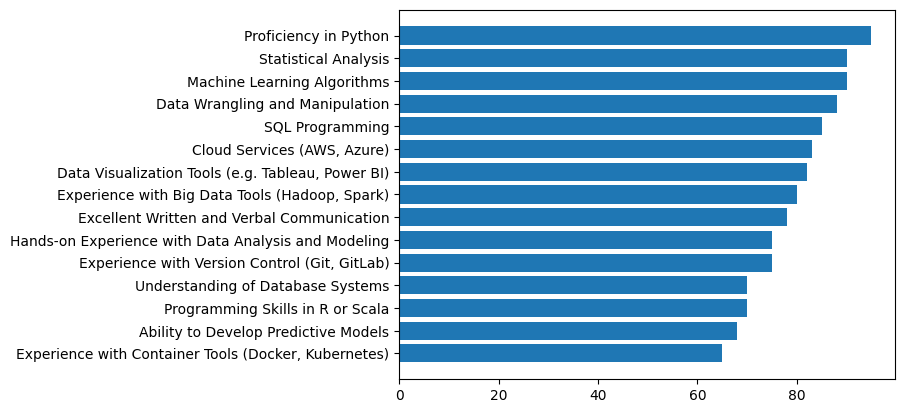

In [45]:
import re
from icecream import ic
# Get the matches of {'skill': <>, 'importance': <>} using regular expression

pattern = r"\{\{'skill': '(.*?)', 'importance': (\d{2})\}\}"


skills_matched = re.findall(pattern, result.content)
ic(skills_matched)

data = {}
for skill, rank in skills_matched:
    data[skill] = int(rank)

sorted_data = sorted(zip(data.values(), data.keys()), reverse=False)
values, categories = zip(*sorted_data)

plt.barh(categories, values)
plt.show()


Final - Pydantic Code

In [9]:

import pandas as pd
skills_matched = [('x','a'),
        ('y','b'),
        ('z','c'),
]
data = {
    'skill': [],
    'rank': [],
    } # Init empty dict to store data
for skill, rank in skills_matched: # Go through the matches
    data["skill"].append(skill)
    data["rank"].append(rank)
sorted_data = pd.DataFrame(data).sort_values(by="rank", ascending=False)
sorted_data

,skill,rank
2,z,c
1,y,b
0,x,a


C:\Users\sumag\AppData\Roaming\Python\Python312\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...

Invoking: `job_search` with `{'query': 'Data Scientist'}`


Working with the University Data Office, the Data Scientist develops data products and solutions that help advance the mission and supports the strategies of the institution. In this role, the Data Scientist harnesses their expertise in data science and technology to gather, analyze, and interpret diverse data sets, derives actionable insights, and makes strategic inferences to tackle challenging business problems.

KEY RESPONSIBILITIES:
• Designs, develops, and operationalizes data solutions that provide actionable insights, supporting decision-making processes across the institution.
• Leads the collection of new data and refines, processes, and integrates existing data sources.
• Conducts data analysis, develops insights, and communicates results effectively to stakeholders.
• Develops deep expertise in the data and processes of the institution, acting as the data liaison.
• Performs

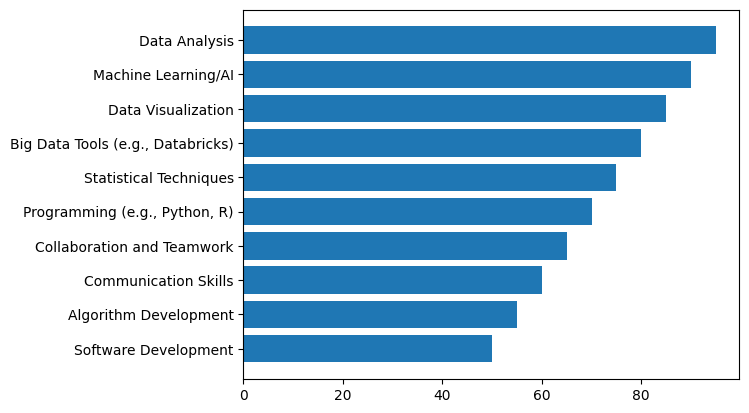

In [12]:
import os
from typing import Type

from dotenv import load_dotenv
from langchain import hub
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langchain.embeddings import HuggingFaceEmbeddings

import matplotlib.pyplot as plt

load_dotenv()

"""TOOLS"""

# 1. --- Database accessing tool --- 
class ChromaDBQueryJobsInput(BaseModel):
    query: str = Field(description="Job Search query")

class ChromaDBQueryJobsTool(BaseTool):
    name: str = "job_search" # The AI does not care where (ChromaDB) the datacomes from!!
    description: str = """SEARCH JOBS FIRST. Finds job postings in database."""
    args_schema: Type[BaseModel] = ChromaDBQueryJobsInput

    def _run(self, query: str) -> str:
        # Set the directory
        current_dir = os.getcwd() # NOTE: use this for .ipynb files
        persistent_directory = os.path.join(current_dir, "db", "chroma_db_with_metadata")

        # Set the model
        embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-mpnet-base-v2"
        )

        # Set the database 
        collection_name = "jobs_collection"
        db = Chroma(
            persist_directory=persistent_directory,
            embedding_function=embeddings,
            collection_name=collection_name  # Match the name used in push
        )

        # Set the retriever
        retriever = db.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={"k": 10, "score_threshold": 0.25},  # Lower threshold for testing
        )

        # Query the database via .invoke() 
        relevant_docs = retriever.invoke(query)
        
        rel_docs_content = "\n\n".join([doc.page_content for doc in relevant_docs])
        
        # Return the content of the relevant docs 
        return rel_docs_content

# 2. --- Skill Ranking Tool --- 
class SkillRankingInput(BaseModel):
    job_descriptions: str = Field(description="Job descriptions from job_search")
    user_job_query: str = Field(description="The user's query to find the skills for their specific job title/field")

class SkillRankingTool(BaseTool):
    name: str = "skill_ranking"
    description: str = """ANALYZE JOB POSTINGS TO IDENTIFY SKILLS. 
                            MUST BE USED AFTER chromadb_search."""
    args_schema: Type[BaseModel] = SkillRankingInput

    def _run(self, job_descriptions, user_job_query) -> dict: 
        combined_input = (
        "Here are some documents that might help answer the question: "
        + user_job_query
        + "\n\nRelevant Documents:\n"
        + job_descriptions
        + "\n\nPlease extract the top skills for the following job posting and their importance (on a scale from 1 to 100):\nReturn the skills in this format: [{{'skill': 'Skill Name', 'importance': 95}}, ...]"
        )
        jobs_ranked = ChatOpenAI(model="gpt-4o").invoke(combined_input)
        pattern = r"\{\{'skill': '(.*?)', 'importance': (\d{2})\}\}"
        skills_matched = re.findall(pattern, jobs_ranked.content)
        data = {} # Init empty dict to store data
        for skill, rank in skills_matched: # Go through the matches
            data[skill] = int(rank)
        
        sorted_data = sorted(zip(data.values(), data.keys()), reverse=False)
        values, categories = zip(*sorted_data)

        plot_file_name = "skills_plot.png"
        plt.barh(categories, values)
        plt.savefig(plot_file_name)
        return f"Saved figure as: {plot_file_name}" + "\n" + str(jobs_ranked.content)


# Create tools using the Pydantic subclass approach
tools = [
    ChromaDBQueryJobsTool(),
    SkillRankingTool(),
]

"""OpenAI Model"""
llm = ChatOpenAI(model="gpt-4o")

# Pull the prompt template from the hub
prompt = hub.pull("hwchase17/openai-tools-agent") # Prompt template that's more prone to utilizing pydantic tools 

# Create the ReAct agent using the create_tool_calling_agent function
agent = create_tool_calling_agent(
    llm=llm,
    tools=tools,
    prompt=prompt,
)

# Create the agent executor
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
)

"""TESTING"""

user_request = """Give me rankings of data scientists skills needed to land a data science job. Please plot the output into a graph"""

# Test the agent with sample queries
response = agent_executor.invoke({"input": user_request})
print(f"Response for '{user_request}':", response)
